In [1]:
# (token方向に)AvgPool -> (embed方向に)LayerNorm
# 0.1はwarmup
# gradient_accumulation_steps = 2
# roberta-large

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='031'
    debug=False  # False
    wandb=True
    resume= None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="roberta-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=5
    gradient_accumulation_steps=2
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Sat Jun 18 14:03:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 2.9 MB/s 
CPU times: user 984 ms, sys: 214 ms, total: 1.2 s
Wall time: 24.8 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        # id='3bwalqa8',
                        anonymous=anony)

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 145 kB 56.1 MB/s 
     |████████████████████████████████| 181 kB 56.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [ ]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

# EDA

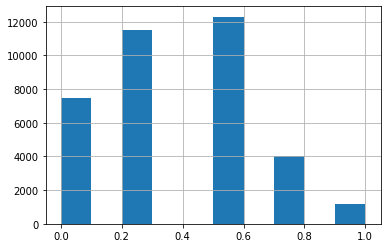

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 175


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]
        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        out = sum_embeddings / sum_mask
        
        out = self.layer_norm1(out)
        output = self.fc(out)
                
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size / CFG.gradient_accumulation_steps * CFG.epochs)
    CFG.num_warmup_steps = num_train_steps * 0.1
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    # if wandb.run.resumed:
    #     checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
    #     if checkpoint['epoch'] < CFG.epochs-1:  # foldの終わりで止まっている時もある
    #         model.load_state_dict(checkpoint['model'])
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #         scheduler.load_state_dict(checkpoint['scheduler'])
    #         # amp.load_state_dict(checkpoint['amp'])
    #         epoch = checkpoint['epoch'] + 1  # 保存時のエポックが読み出されるので+1
    #         best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 1s (remain 29m 17s) Loss: 0.4016(0.4016) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1693] Elapsed 1m 30s (remain 23m 43s) Loss: 0.3607(0.3820) Grad: 37019.6523  LR: 0.00000236  
Epoch: [1][200/1693] Elapsed 2m 59s (remain 22m 14s) Loss: 0.3206(0.3556) Grad: 10648.8926  LR: 0.00000472  
Epoch: [1][300/1693] Elapsed 4m 29s (remain 20m 44s) Loss: 0.3222(0.3443) Grad: 19683.1758  LR: 0.00000709  
Epoch: [1][400/1693] Elapsed 5m 58s (remain 19m 15s) Loss: 0.2856(0.3377) Grad: 16328.3057  LR: 0.00000945  
Epoch: [1][500/1693] Elapsed 7m 28s (remain 17m 45s) Loss: 0.2956(0.3319) Grad: 21526.1016  LR: 0.00001181  
Epoch: [1][600/1693] Elapsed 8m 57s (remain 16m 16s) Loss: 0.2957(0.3280) Grad: 25848.2695  LR: 0.00001417  
Epoch: [1][700/1693] Elapsed 10m 26s (remain 14m 46s) Loss: 0.3298(0.3245) Grad: 28692.1836  LR: 0.00001654  
Epoch: [1][800/1693] Elapsed 11m 56s (remain 13m 17s) Loss: 0.3462(0.3218) Grad: 39745.5703  LR: 0.00001890  
Epoch: [1][900/1693] Elapse

Epoch 1 - avg_train_loss: 0.3077  avg_val_loss: 0.2839  time: 1685s
Epoch 1 - Score: 0.7574


EVAL: [586/587] Elapsed 2m 50s (remain 0m 0s) Loss: 0.3610(0.2839) 


Epoch 1 - Save Best Score: 0.7574 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 35m 7s) Loss: 0.2126(0.2126) Grad: 59189.3320  LR: 0.00001940  
Epoch: [2][100/1693] Elapsed 1m 30s (remain 23m 53s) Loss: 0.3271(0.2753) Grad: 113600.2812  LR: 0.00001925  
Epoch: [2][200/1693] Elapsed 3m 0s (remain 22m 19s) Loss: 0.2920(0.2773) Grad: 40020.2734  LR: 0.00001909  
Epoch: [2][300/1693] Elapsed 4m 29s (remain 20m 47s) Loss: 0.2517(0.2770) Grad: 37682.4531  LR: 0.00001891  
Epoch: [2][400/1693] Elapsed 5m 59s (remain 19m 17s) Loss: 0.2506(0.2776) Grad: 83276.1250  LR: 0.00001871  
Epoch: [2][500/1693] Elapsed 7m 28s (remain 17m 47s) Loss: 0.2557(0.2783) Grad: 92631.1250  LR: 0.00001850  
Epoch: [2][600/1693] Elapsed 8m 58s (remain 16m 17s) Loss: 0.3261(0.2785) Grad: 63713.4336  LR: 0.00001828  
Epoch: [2][700/1693] Elapsed 10m 27s (remain 14m 48s) Loss: 0.1968(0.2778) Grad: 28014.6426  LR: 0.00001804  
Epoch: [2][800/1693] Elapsed 11m 57s (remain 13m 18s) Loss: 0.3341(0.2774) Grad: 77488.0938  LR: 0.00001779  
Epoch: [2][900/1693] 

Epoch 2 - avg_train_loss: 0.2762  avg_val_loss: 0.2803  time: 1684s
Epoch 2 - Score: 0.7887


EVAL: [586/587] Elapsed 2m 49s (remain 0m 0s) Loss: 0.3404(0.2803) 


Epoch 2 - Save Best Score: 0.7887 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 30m 23s) Loss: 0.2796(0.2796) Grad: 100680.0000  LR: 0.00001501  
Epoch: [3][100/1693] Elapsed 1m 30s (remain 23m 50s) Loss: 0.2716(0.2724) Grad: 40710.4023  LR: 0.00001465  
Epoch: [3][200/1693] Elapsed 3m 0s (remain 22m 17s) Loss: 0.2499(0.2745) Grad: 19450.4551  LR: 0.00001428  
Epoch: [3][300/1693] Elapsed 4m 29s (remain 20m 46s) Loss: 0.2607(0.2735) Grad: 29271.3887  LR: 0.00001390  
Epoch: [3][400/1693] Elapsed 5m 59s (remain 19m 16s) Loss: 0.2580(0.2738) Grad: 36626.8477  LR: 0.00001352  
Epoch: [3][500/1693] Elapsed 7m 28s (remain 17m 47s) Loss: 0.2661(0.2730) Grad: 37878.4805  LR: 0.00001313  
Epoch: [3][600/1693] Elapsed 8m 57s (remain 16m 17s) Loss: 0.2460(0.2724) Grad: 47262.0273  LR: 0.00001274  
Epoch: [3][700/1693] Elapsed 10m 27s (remain 14m 47s) Loss: 0.2993(0.2731) Grad: 35697.5117  LR: 0.00001234  
Epoch: [3][800/1693] Elapsed 11m 56s (remain 13m 18s) Loss: 0.2850(0.2725) Grad: 11279.7578  LR: 0.00001194  
Epoch: [3][900/1693]

Epoch 3 - avg_train_loss: 0.2714  avg_val_loss: 0.2841  time: 1684s
Epoch 3 - Score: 0.7940


EVAL: [586/587] Elapsed 2m 49s (remain 0m 0s) Loss: 0.3459(0.2841) 


Epoch 3 - Save Best Score: 0.7940 Model


Epoch: [4][0/1693] Elapsed 0m 1s (remain 35m 48s) Loss: 0.2813(0.2813) Grad: 66550.2188  LR: 0.00000828  
Epoch: [4][100/1693] Elapsed 1m 31s (remain 23m 54s) Loss: 0.3025(0.2655) Grad: 39882.9766  LR: 0.00000787  
Epoch: [4][200/1693] Elapsed 3m 0s (remain 22m 19s) Loss: 0.2184(0.2664) Grad: 60106.2188  LR: 0.00000747  
Epoch: [4][300/1693] Elapsed 4m 29s (remain 20m 48s) Loss: 0.2693(0.2654) Grad: 23829.8926  LR: 0.00000708  
Epoch: [4][400/1693] Elapsed 5m 59s (remain 19m 17s) Loss: 0.2801(0.2660) Grad: 40387.2539  LR: 0.00000668  
Epoch: [4][500/1693] Elapsed 7m 28s (remain 17m 47s) Loss: 0.2835(0.2657) Grad: 27215.4844  LR: 0.00000630  
Epoch: [4][600/1693] Elapsed 8m 58s (remain 16m 17s) Loss: 0.2528(0.2653) Grad: 38651.3203  LR: 0.00000592  
Epoch: [4][700/1693] Elapsed 10m 27s (remain 14m 48s) Loss: 0.2974(0.2656) Grad: 19608.9805  LR: 0.00000555  
Epoch: [4][800/1693] Elapsed 11m 57s (remain 13m 18s) Loss: 0.2182(0.2648) Grad: 35542.6211  LR: 0.00000518  
Epoch: [4][900/1693] 

Epoch 4 - avg_train_loss: 0.2648  avg_val_loss: 0.2811  time: 1684s
Epoch 4 - Score: 0.8001


EVAL: [586/587] Elapsed 2m 49s (remain 0m 0s) Loss: 0.3429(0.2811) 


Epoch 4 - Save Best Score: 0.8001 Model


Epoch: [5][0/1693] Elapsed 0m 1s (remain 33m 21s) Loss: 0.2713(0.2713) Grad: inf  LR: 0.00000235  
Epoch: [5][100/1693] Elapsed 1m 30s (remain 23m 51s) Loss: 0.2587(0.2557) Grad: 24348.6562  LR: 0.00000209  
Epoch: [5][200/1693] Elapsed 3m 0s (remain 22m 18s) Loss: 0.2671(0.2596) Grad: 55081.4180  LR: 0.00000185  
Epoch: [5][300/1693] Elapsed 4m 29s (remain 20m 47s) Loss: 0.2859(0.2626) Grad: 24268.0781  LR: 0.00000162  
Epoch: [5][400/1693] Elapsed 5m 59s (remain 19m 17s) Loss: 0.2873(0.2627) Grad: 87404.3984  LR: 0.00000140  
Epoch: [5][500/1693] Elapsed 7m 28s (remain 17m 47s) Loss: 0.2176(0.2622) Grad: 28261.2617  LR: 0.00000120  
Epoch: [5][600/1693] Elapsed 8m 58s (remain 16m 17s) Loss: 0.2144(0.2617) Grad: 49720.0664  LR: 0.00000101  
Epoch: [5][700/1693] Elapsed 10m 27s (remain 14m 48s) Loss: 0.2419(0.2610) Grad: 13102.3975  LR: 0.00000083  
Epoch: [5][800/1693] Elapsed 11m 57s (remain 13m 18s) Loss: 0.2832(0.2608) Grad: 12306.9902  LR: 0.00000068  
Epoch: [5][900/1693] Elapsed

Epoch 5 - avg_train_loss: 0.2614  avg_val_loss: 0.2824  time: 1684s
Epoch 5 - Score: 0.8001


EVAL: [586/587] Elapsed 2m 49s (remain 0m 0s) Loss: 0.3419(0.2824) 


Epoch 5 - Save Best Score: 0.8001 Model
========== fold: 0 result ==========
Score: 0.8001
========== fold: 1 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1725] Elapsed 0m 1s (remain 35m 18s) Loss: 0.2828(0.2828) Grad: 48215.4453  LR: 0.00000000  
Epoch: [1][100/1725] Elapsed 1m 30s (remain 24m 22s) Loss: 0.3262(0.3332) Grad: 38105.0586  LR: 0.00000232  
Epoch: [1][200/1725] Elapsed 3m 0s (remain 22m 48s) Loss: 0.3172(0.3293) Grad: 35383.2773  LR: 0.00000464  
Epoch: [1][300/1725] Elapsed 4m 29s (remain 21m 16s) Loss: 0.3370(0.3275) Grad: 240900.3906  LR: 0.00000695  
Epoch: [1][400/1725] Elapsed 5m 59s (remain 19m 46s) Loss: 0.2989(0.3249) Grad: 27801.7539  LR: 0.00000927  
Epoch: [1][500/1725] Elapsed 7m 28s (remain 18m 16s) Loss: 0.3134(0.3223) Grad: 35983.8906  LR: 0.00001159  
Epoch: [1][600/1725] Elapsed 8m 58s (remain 16m 46s) Loss: 0.2912(0.3198) Grad: 34646.5938  LR: 0.00001391  
Epoch: [1][700/1725] Elapsed 10m 27s (remain 15m 16s) Loss: 0.3361(0.3177) Grad: 79471.1953  LR: 0.00001623  
Epoch: [1][800/1725] Elapsed 11m 57s (remain 13m 47s) Loss: 0.2878(0.3158) Grad: 23853.1953  LR: 0.00001854  
Epoch: [1][900/1725]

Epoch 1 - avg_train_loss: 0.3025  avg_val_loss: 0.2826  time: 1704s
Epoch 1 - Score: 0.7561


EVAL: [553/554] Elapsed 2m 39s (remain 0m 0s) Loss: 0.2596(0.2826) 


Epoch 1 - Save Best Score: 0.7561 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 32m 9s) Loss: 0.3343(0.3343) Grad: 248225.2969  LR: 0.00001940  
Epoch: [2][100/1725] Elapsed 1m 30s (remain 24m 20s) Loss: 0.2590(0.2806) Grad: 15255.2295  LR: 0.00001925  
Epoch: [2][200/1725] Elapsed 3m 0s (remain 22m 46s) Loss: 0.2576(0.2819) Grad: 23148.8750  LR: 0.00001909  
Epoch: [2][300/1725] Elapsed 4m 29s (remain 21m 15s) Loss: 0.2409(0.2807) Grad: 26875.9297  LR: 0.00001892  
Epoch: [2][400/1725] Elapsed 5m 59s (remain 19m 45s) Loss: 0.2911(0.2798) Grad: 23209.3125  LR: 0.00001873  
Epoch: [2][500/1725] Elapsed 7m 28s (remain 18m 15s) Loss: 0.2975(0.2806) Grad: 44819.8164  LR: 0.00001852  
Epoch: [2][600/1725] Elapsed 8m 57s (remain 16m 46s) Loss: 0.2977(0.2805) Grad: 32981.0859  LR: 0.00001830  
Epoch: [2][700/1725] Elapsed 10m 27s (remain 15m 16s) Loss: 0.2766(0.2801) Grad: 55602.8633  LR: 0.00001807  
Epoch: [2][800/1725] Elapsed 11m 56s (remain 13m 46s) Loss: 0.2917(0.2800) Grad: 57588.9688  LR: 0.00001783  
Epoch: [2][900/1725] 

Epoch 2 - avg_train_loss: 0.2788  avg_val_loss: 0.2789  time: 1704s
Epoch 2 - Score: 0.7757


EVAL: [553/554] Elapsed 2m 40s (remain 0m 0s) Loss: 0.2627(0.2789) 


Epoch 2 - Save Best Score: 0.7757 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 30m 32s) Loss: 0.2584(0.2584) Grad: 99905.3594  LR: 0.00001501  
Epoch: [3][100/1725] Elapsed 1m 30s (remain 24m 20s) Loss: 0.2432(0.2715) Grad: 41134.6875  LR: 0.00001466  
Epoch: [3][200/1725] Elapsed 3m 0s (remain 22m 48s) Loss: 0.2659(0.2707) Grad: 157907.9375  LR: 0.00001430  
Epoch: [3][300/1725] Elapsed 4m 30s (remain 21m 17s) Loss: 0.1570(0.2685) Grad: 117463.1406  LR: 0.00001393  
Epoch: [3][400/1725] Elapsed 5m 59s (remain 19m 47s) Loss: 0.2851(0.2690) Grad: 22119.8145  LR: 0.00001355  
Epoch: [3][500/1725] Elapsed 7m 29s (remain 18m 17s) Loss: 0.2762(0.2679) Grad: 20335.8613  LR: 0.00001317  
Epoch: [3][600/1725] Elapsed 8m 58s (remain 16m 47s) Loss: 0.2683(0.2675) Grad: 28853.4766  LR: 0.00001278  
Epoch: [3][700/1725] Elapsed 10m 28s (remain 15m 17s) Loss: 0.3101(0.2679) Grad: 118311.6641  LR: 0.00001239  
Epoch: [3][800/1725] Elapsed 11m 57s (remain 13m 47s) Loss: 0.2972(0.2686) Grad: 22548.2734  LR: 0.00001200  
Epoch: [3][900/172

Epoch 3 - avg_train_loss: 0.2706  avg_val_loss: 0.2798  time: 1706s
Epoch 3 - Score: 0.7891


EVAL: [553/554] Elapsed 2m 40s (remain 0m 0s) Loss: 0.2549(0.2798) 


Epoch 3 - Save Best Score: 0.7891 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 31m 23s) Loss: 0.2940(0.2940) Grad: 134960.4062  LR: 0.00000828  
Epoch: [4][100/1725] Elapsed 1m 30s (remain 24m 20s) Loss: 0.2591(0.2627) Grad: 68902.9844  LR: 0.00000789  
Epoch: [4][200/1725] Elapsed 3m 0s (remain 22m 47s) Loss: 0.3192(0.2645) Grad: 85215.1250  LR: 0.00000749  
Epoch: [4][300/1725] Elapsed 4m 29s (remain 21m 16s) Loss: 0.2452(0.2642) Grad: 93003.3984  LR: 0.00000710  
Epoch: [4][400/1725] Elapsed 5m 59s (remain 19m 46s) Loss: 0.2850(0.2645) Grad: 119377.0703  LR: 0.00000672  
Epoch: [4][500/1725] Elapsed 7m 28s (remain 18m 16s) Loss: 0.2080(0.2640) Grad: 68197.5547  LR: 0.00000634  
Epoch: [4][600/1725] Elapsed 8m 58s (remain 16m 46s) Loss: 0.2997(0.2648) Grad: 122989.4766  LR: 0.00000597  
Epoch: [4][700/1725] Elapsed 10m 27s (remain 15m 16s) Loss: 0.2507(0.2644) Grad: 40452.7734  LR: 0.00000560  
Epoch: [4][800/1725] Elapsed 11m 57s (remain 13m 47s) Loss: 0.2687(0.2641) Grad: 17507.2930  LR: 0.00000524  
Epoch: [4][900/172

Epoch 4 - avg_train_loss: 0.2628  avg_val_loss: 0.2797  time: 1704s
Epoch 4 - Score: 0.7967


EVAL: [553/554] Elapsed 2m 40s (remain 0m 0s) Loss: 0.2522(0.2797) 


Epoch 4 - Save Best Score: 0.7967 Model


Epoch: [5][0/1725] Elapsed 0m 1s (remain 31m 43s) Loss: 0.2443(0.2443) Grad: 70959.9375  LR: 0.00000236  
Epoch: [5][100/1725] Elapsed 1m 30s (remain 24m 20s) Loss: 0.2740(0.2548) Grad: 61172.9648  LR: 0.00000210  
Epoch: [5][200/1725] Elapsed 3m 0s (remain 22m 47s) Loss: 0.2749(0.2579) Grad: 31903.0547  LR: 0.00000186  
Epoch: [5][300/1725] Elapsed 4m 29s (remain 21m 16s) Loss: 0.2168(0.2576) Grad: 39464.1172  LR: 0.00000163  
Epoch: [5][400/1725] Elapsed 5m 59s (remain 19m 46s) Loss: 0.2131(0.2577) Grad: 57292.8398  LR: 0.00000142  
Epoch: [5][500/1725] Elapsed 7m 28s (remain 18m 16s) Loss: 0.2397(0.2589) Grad: 44228.5312  LR: 0.00000122  
Epoch: [5][600/1725] Elapsed 8m 58s (remain 16m 46s) Loss: 0.2297(0.2586) Grad: 69773.4453  LR: 0.00000103  
Epoch: [5][700/1725] Elapsed 10m 27s (remain 15m 16s) Loss: 0.1945(0.2589) Grad: 40052.2500  LR: 0.00000086  
Epoch: [5][800/1725] Elapsed 11m 57s (remain 13m 47s) Loss: 0.2576(0.2589) Grad: 26404.9082  LR: 0.00000070  
Epoch: [5][900/1725] 

Epoch 5 - avg_train_loss: 0.2599  avg_val_loss: 0.2821  time: 1704s
Epoch 5 - Score: 0.7938


EVAL: [553/554] Elapsed 2m 40s (remain 0m 0s) Loss: 0.2519(0.2821) 


========== fold: 1 result ==========
Score: 0.7967
========== fold: 2 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1741] Elapsed 0m 1s (remain 33m 51s) Loss: 0.3751(0.3751) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1741] Elapsed 1m 30s (remain 24m 31s) Loss: 0.3167(0.3530) Grad: 4577.7158  LR: 0.00000230  
Epoch: [1][200/1741] Elapsed 3m 0s (remain 23m 0s) Loss: 0.3221(0.3399) Grad: 3055.3696  LR: 0.00000459  
Epoch: [1][300/1741] Elapsed 4m 29s (remain 21m 29s) Loss: 0.2946(0.3321) Grad: 8500.7109  LR: 0.00000689  
Epoch: [1][400/1741] Elapsed 5m 59s (remain 19m 59s) Loss: 0.3349(0.3281) Grad: 4626.8174  LR: 0.00000919  
Epoch: [1][500/1741] Elapsed 7m 28s (remain 18m 30s) Loss: 0.3385(0.3251) Grad: 1869.4170  LR: 0.00001149  
Epoch: [1][600/1741] Elapsed 8m 57s (remain 17m 0s) Loss: 0.2712(0.3221) Grad: 4161.7017  LR: 0.00001378  
Epoch: [1][700/1741] Elapsed 10m 27s (remain 15m 30s) Loss: 0.2930(0.3192) Grad: 4815.1196  LR: 0.00001608  
Epoch: [1][800/1741] Elapsed 11m 56s (remain 14m 1s) Loss: 0.2209(0.3157) Grad: 4046.4836  LR: 0.00001838  
Epoch: [1][900/1741] Elapsed 13m 26s (r

Epoch 1 - avg_train_loss: 0.3006  avg_val_loss: 0.2866  time: 1714s
Epoch 1 - Score: 0.7611


EVAL: [538/539] Elapsed 2m 35s (remain 0m 0s) Loss: 0.2086(0.2866) 


Epoch 1 - Save Best Score: 0.7611 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 30m 50s) Loss: 0.3062(0.3062) Grad: inf  LR: 0.00001940  
Epoch: [2][100/1741] Elapsed 1m 30s (remain 24m 35s) Loss: 0.2678(0.2737) Grad: 26525.6738  LR: 0.00001925  
Epoch: [2][200/1741] Elapsed 3m 0s (remain 23m 1s) Loss: 0.2750(0.2734) Grad: 22875.5586  LR: 0.00001909  
Epoch: [2][300/1741] Elapsed 4m 29s (remain 21m 30s) Loss: 0.2688(0.2736) Grad: 32544.2500  LR: 0.00001892  
Epoch: [2][400/1741] Elapsed 5m 59s (remain 20m 0s) Loss: 0.2618(0.2727) Grad: 30815.0566  LR: 0.00001873  
Epoch: [2][500/1741] Elapsed 7m 28s (remain 18m 30s) Loss: 0.2925(0.2724) Grad: 58995.1406  LR: 0.00001853  
Epoch: [2][600/1741] Elapsed 8m 58s (remain 17m 1s) Loss: 0.3118(0.2715) Grad: 74024.6328  LR: 0.00001831  
Epoch: [2][700/1741] Elapsed 10m 27s (remain 15m 31s) Loss: 0.3029(0.2716) Grad: 28759.4551  LR: 0.00001808  
Epoch: [2][800/1741] Elapsed 11m 57s (remain 14m 1s) Loss: 0.2724(0.2723) Grad: 17679.7363  LR: 0.00001784  
Epoch: [2][900/1741] Elapsed 13m

Epoch 2 - avg_train_loss: 0.2722  avg_val_loss: 0.2801  time: 1715s
Epoch 2 - Score: 0.7853


EVAL: [538/539] Elapsed 2m 35s (remain 0m 0s) Loss: 0.1788(0.2801) 


Epoch 2 - Save Best Score: 0.7853 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 29m 47s) Loss: 0.2898(0.2898) Grad: 186972.8906  LR: 0.00001501  
Epoch: [3][100/1741] Elapsed 1m 30s (remain 24m 34s) Loss: 0.2955(0.2684) Grad: 32908.7891  LR: 0.00001466  
Epoch: [3][200/1741] Elapsed 3m 0s (remain 23m 2s) Loss: 0.2014(0.2695) Grad: 36986.2852  LR: 0.00001430  
Epoch: [3][300/1741] Elapsed 4m 29s (remain 21m 31s) Loss: 0.2740(0.2666) Grad: 64112.4844  LR: 0.00001393  
Epoch: [3][400/1741] Elapsed 5m 59s (remain 20m 1s) Loss: 0.2662(0.2677) Grad: 34677.9570  LR: 0.00001356  
Epoch: [3][500/1741] Elapsed 7m 28s (remain 18m 31s) Loss: 0.2760(0.2687) Grad: 31025.8027  LR: 0.00001318  
Epoch: [3][600/1741] Elapsed 8m 58s (remain 17m 1s) Loss: 0.3006(0.2688) Grad: 27867.1836  LR: 0.00001280  
Epoch: [3][700/1741] Elapsed 10m 27s (remain 15m 31s) Loss: 0.2586(0.2693) Grad: 9597.7148  LR: 0.00001241  
Epoch: [3][800/1741] Elapsed 11m 57s (remain 14m 1s) Loss: 0.2890(0.2696) Grad: 10206.9688  LR: 0.00001202  
Epoch: [3][900/1741] Elap

Epoch 3 - avg_train_loss: 0.2686  avg_val_loss: 0.2804  time: 1714s
Epoch 3 - Score: 0.7934


EVAL: [538/539] Elapsed 2m 35s (remain 0m 0s) Loss: 0.1926(0.2804) 


Epoch 3 - Save Best Score: 0.7934 Model


Epoch: [4][0/1741] Elapsed 0m 1s (remain 30m 52s) Loss: 0.2355(0.2355) Grad: 90924.1484  LR: 0.00000828  
Epoch: [4][100/1741] Elapsed 1m 30s (remain 24m 33s) Loss: 0.2595(0.2595) Grad: 763661.0000  LR: 0.00000788  
Epoch: [4][200/1741] Elapsed 3m 0s (remain 23m 1s) Loss: 0.2483(0.2640) Grad: 147553.3906  LR: 0.00000749  
Epoch: [4][300/1741] Elapsed 4m 29s (remain 21m 30s) Loss: 0.2537(0.2635) Grad: 38304.9414  LR: 0.00000711  
Epoch: [4][400/1741] Elapsed 5m 59s (remain 20m 0s) Loss: 0.2766(0.2642) Grad: 56674.6562  LR: 0.00000673  
Epoch: [4][500/1741] Elapsed 7m 28s (remain 18m 30s) Loss: 0.2363(0.2628) Grad: 39094.2188  LR: 0.00000635  
Epoch: [4][600/1741] Elapsed 8m 58s (remain 17m 1s) Loss: 0.2442(0.2637) Grad: 71934.1562  LR: 0.00000598  
Epoch: [4][700/1741] Elapsed 10m 27s (remain 15m 31s) Loss: 0.2258(0.2631) Grad: 19590.3828  LR: 0.00000562  
Epoch: [4][800/1741] Elapsed 11m 57s (remain 14m 1s) Loss: 0.2365(0.2629) Grad: 30053.7344  LR: 0.00000526  
Epoch: [4][900/1741] El

Epoch 4 - avg_train_loss: 0.2642  avg_val_loss: 0.2788  time: 1715s
Epoch 4 - Score: 0.8017


EVAL: [538/539] Elapsed 2m 35s (remain 0m 0s) Loss: 0.1779(0.2788) 


Epoch 4 - Save Best Score: 0.8017 Model


Epoch: [5][0/1741] Elapsed 0m 1s (remain 30m 7s) Loss: 0.1400(0.1400) Grad: 57906.6953  LR: 0.00000235  
Epoch: [5][100/1741] Elapsed 1m 30s (remain 24m 34s) Loss: 0.2819(0.2532) Grad: 39948.8320  LR: 0.00000210  
Epoch: [5][200/1741] Elapsed 3m 0s (remain 23m 1s) Loss: 0.2688(0.2563) Grad: 57044.0625  LR: 0.00000186  
Epoch: [5][300/1741] Elapsed 4m 29s (remain 21m 30s) Loss: 0.2942(0.2590) Grad: 100611.8594  LR: 0.00000163  
Epoch: [5][400/1741] Elapsed 5m 59s (remain 20m 0s) Loss: 0.3008(0.2584) Grad: 18054.1133  LR: 0.00000142  
Epoch: [5][500/1741] Elapsed 7m 28s (remain 18m 30s) Loss: 0.2650(0.2606) Grad: 59414.2109  LR: 0.00000122  
Epoch: [5][600/1741] Elapsed 8m 58s (remain 17m 1s) Loss: 0.2924(0.2613) Grad: 193156.7500  LR: 0.00000104  
Epoch: [5][700/1741] Elapsed 10m 27s (remain 15m 31s) Loss: 0.1767(0.2616) Grad: 37377.0977  LR: 0.00000087  
Epoch: [5][800/1741] Elapsed 11m 57s (remain 14m 1s) Loss: 0.2927(0.2614) Grad: 35448.6914  LR: 0.00000071  
Epoch: [5][900/1741] Ela

Epoch 5 - avg_train_loss: 0.2622  avg_val_loss: 0.2787  time: 1714s
Epoch 5 - Score: 0.8032


EVAL: [538/539] Elapsed 2m 35s (remain 0m 0s) Loss: 0.1783(0.2787) 


Epoch 5 - Save Best Score: 0.8032 Model
========== fold: 2 result ==========
Score: 0.8032
========== fold: 3 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1678] Elapsed 0m 1s (remain 33m 25s) Loss: 0.5030(0.5030) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1678] Elapsed 1m 30s (remain 23m 39s) Loss: 0.3384(0.4059) Grad: 55692.9297  LR: 0.00000238  
Epoch: [1][200/1678] Elapsed 3m 0s (remain 22m 6s) Loss: 0.3230(0.3679) Grad: 15184.0762  LR: 0.00000477  
Epoch: [1][300/1678] Elapsed 4m 30s (remain 20m 35s) Loss: 0.3154(0.3538) Grad: 32024.4238  LR: 0.00000715  
Epoch: [1][400/1678] Elapsed 5m 59s (remain 19m 5s) Loss: 0.3006(0.3446) Grad: 37606.3281  LR: 0.00000954  
Epoch: [1][500/1678] Elapsed 7m 29s (remain 17m 35s) Loss: 0.3049(0.3375) Grad: 21165.7637  LR: 0.00001192  
Epoch: [1][600/1678] Elapsed 8m 58s (remain 16m 5s) Loss: 0.2144(0.3317) Grad: 8797.3447  LR: 0.00001430  
Epoch: [1][700/1678] Elapsed 10m 28s (remain 14m 35s) Loss: 0.3226(0.3290) Grad: 4496.7861  LR: 0.00001669  
Epoch: [1][800/1678] Elapsed 11m 57s (remain 13m 5s) Loss: 0.3224(0.3261) Grad: 4502.7114  LR: 0.00001907  
Epoch: [1][900/1678] Elapsed 13m 27

Epoch 1 - avg_train_loss: 0.3079  avg_val_loss: 0.2885  time: 1677s
Epoch 1 - Score: 0.7372
Epoch 1 - Save Best Score: 0.7372 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 29m 51s) Loss: 0.3249(0.3249) Grad: 151878.5312  LR: 0.00001940  
Epoch: [2][100/1678] Elapsed 1m 30s (remain 23m 37s) Loss: 0.3031(0.2849) Grad: 21415.7227  LR: 0.00001925  
Epoch: [2][200/1678] Elapsed 3m 0s (remain 22m 4s) Loss: 0.2895(0.2824) Grad: 73429.0000  LR: 0.00001908  
Epoch: [2][300/1678] Elapsed 4m 29s (remain 20m 34s) Loss: 0.3077(0.2799) Grad: 11797.4609  LR: 0.00001890  
Epoch: [2][400/1678] Elapsed 5m 59s (remain 19m 4s) Loss: 0.2705(0.2797) Grad: 37966.9375  LR: 0.00001870  
Epoch: [2][500/1678] Elapsed 7m 28s (remain 17m 34s) Loss: 0.2495(0.2782) Grad: 8230.0449  LR: 0.00001849  
Epoch: [2][600/1678] Elapsed 8m 58s (remain 16m 4s) Loss: 0.2815(0.2771) Grad: 20627.4629  LR: 0.00001826  
Epoch: [2][700/1678] Elapsed 10m 27s (remain 14m 34s) Loss: 0.3262(0.2762) Grad: 34578.3633  LR: 0.00001802  
Epoch: [2][800/1678] Elapsed 11m 57s (remain 13m 5s) Loss: 0.2578(0.2755) Grad: 7649.3516  LR: 0.00001776  
Epoch: [2][900/1678] Elaps

Epoch 2 - avg_train_loss: 0.2742  avg_val_loss: 0.2842  time: 1676s
Epoch 2 - Score: 0.7653
Epoch 2 - Save Best Score: 0.7653 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 30m 31s) Loss: 0.2851(0.2851) Grad: 181763.7188  LR: 0.00001500  
Epoch: [3][100/1678] Elapsed 1m 30s (remain 23m 39s) Loss: 0.2427(0.2666) Grad: 46575.0078  LR: 0.00001464  
Epoch: [3][200/1678] Elapsed 3m 0s (remain 22m 6s) Loss: 0.2405(0.2652) Grad: 45275.8398  LR: 0.00001426  
Epoch: [3][300/1678] Elapsed 4m 29s (remain 20m 35s) Loss: 0.2547(0.2663) Grad: 82060.8438  LR: 0.00001388  
Epoch: [3][400/1678] Elapsed 5m 59s (remain 19m 4s) Loss: 0.2736(0.2676) Grad: 81463.0547  LR: 0.00001350  
Epoch: [3][500/1678] Elapsed 7m 28s (remain 17m 34s) Loss: 0.2800(0.2672) Grad: 27461.5000  LR: 0.00001310  
Epoch: [3][600/1678] Elapsed 8m 58s (remain 16m 4s) Loss: 0.2897(0.2675) Grad: 10490.8408  LR: 0.00001271  
Epoch: [3][700/1678] Elapsed 10m 27s (remain 14m 35s) Loss: 0.3330(0.2680) Grad: 53811.7695  LR: 0.00001230  
Epoch: [3][800/1678] Elapsed 11m 57s (remain 13m 5s) Loss: 0.2577(0.2679) Grad: 19779.4512  LR: 0.00001190  
Epoch: [3][900/1678] Ela

Epoch 3 - avg_train_loss: 0.2663  avg_val_loss: 0.2843  time: 1677s
Epoch 3 - Score: 0.7711
Epoch 3 - Save Best Score: 0.7711 Model


Epoch: [4][0/1678] Elapsed 0m 1s (remain 33m 10s) Loss: 0.2948(0.2948) Grad: 212268.0781  LR: 0.00000826  
Epoch: [4][100/1678] Elapsed 1m 31s (remain 23m 40s) Loss: 0.2310(0.2679) Grad: 30184.3945  LR: 0.00000786  
Epoch: [4][200/1678] Elapsed 3m 0s (remain 22m 6s) Loss: 0.2480(0.2639) Grad: 78599.0000  LR: 0.00000745  
Epoch: [4][300/1678] Elapsed 4m 30s (remain 20m 35s) Loss: 0.3096(0.2644) Grad: 50621.7070  LR: 0.00000705  
Epoch: [4][400/1678] Elapsed 5m 59s (remain 19m 5s) Loss: 0.3464(0.2650) Grad: 303072.8750  LR: 0.00000666  
Epoch: [4][500/1678] Elapsed 7m 29s (remain 17m 34s) Loss: 0.3294(0.2639) Grad: 173555.1562  LR: 0.00000627  
Epoch: [4][600/1678] Elapsed 8m 58s (remain 16m 4s) Loss: 0.2571(0.2631) Grad: 12876.6445  LR: 0.00000588  
Epoch: [4][700/1678] Elapsed 10m 27s (remain 14m 35s) Loss: 0.2578(0.2637) Grad: 24690.4844  LR: 0.00000551  
Epoch: [4][800/1678] Elapsed 11m 57s (remain 13m 5s) Loss: 0.2081(0.2633) Grad: 18996.5410  LR: 0.00000514  
Epoch: [4][900/1678] E

Epoch 4 - avg_train_loss: 0.2626  avg_val_loss: 0.2867  time: 1677s
Epoch 4 - Score: 0.7735
Epoch 4 - Save Best Score: 0.7735 Model


Epoch: [5][0/1678] Elapsed 0m 1s (remain 30m 40s) Loss: 0.2429(0.2429) Grad: 53680.4922  LR: 0.00000234  
Epoch: [5][100/1678] Elapsed 1m 30s (remain 23m 40s) Loss: 0.2551(0.2642) Grad: 94788.0469  LR: 0.00000208  
Epoch: [5][200/1678] Elapsed 3m 0s (remain 22m 6s) Loss: 0.2577(0.2629) Grad: 40619.2266  LR: 0.00000183  
Epoch: [5][300/1678] Elapsed 4m 30s (remain 20m 35s) Loss: 0.2140(0.2624) Grad: 102396.5781  LR: 0.00000160  
Epoch: [5][400/1678] Elapsed 5m 59s (remain 19m 4s) Loss: 0.2473(0.2617) Grad: 18616.1797  LR: 0.00000138  
Epoch: [5][500/1678] Elapsed 7m 28s (remain 17m 34s) Loss: 0.2158(0.2616) Grad: 8731.6055  LR: 0.00000118  
Epoch: [5][600/1678] Elapsed 8m 58s (remain 16m 4s) Loss: 0.1917(0.2601) Grad: 115159.2109  LR: 0.00000099  
Epoch: [5][700/1678] Elapsed 10m 27s (remain 14m 35s) Loss: 0.2763(0.2596) Grad: 15039.0850  LR: 0.00000082  
Epoch: [5][800/1678] Elapsed 11m 57s (remain 13m 5s) Loss: 0.2840(0.2609) Grad: 15510.2686  LR: 0.00000066  
Epoch: [5][900/1678] Ela

Epoch 5 - avg_train_loss: 0.2612  avg_val_loss: 0.2857  time: 1676s
Epoch 5 - Score: 0.7767
Epoch 5 - Save Best Score: 0.7767 Model
========== fold: 3 result ==========
Score: 0.7767
========== CV ==========
Score: 0.7927


[fold0] avg_train_loss,█▃▃▂▁
[fold0] avg_val_loss,█▁█▂▅
[fold0] epoch,▁▃▅▆█
[fold0] loss,▅▅▆▃▅▅▅▅▅▅▅▃▃▃▄▅▄▆▄▁▂▄▄▃▄▂▇▃▃▃▃▄▂▂█▂▄▄▄▄
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆▇██
[fold1] avg_train_loss,█▄▃▁▁
[fold1] avg_val_loss,█▁▃▂▇
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▇▇▇▇▅▃▄▆▅▆▁▅▄▅▆▅▁▁▂▄▄▂▆▃▃▃▅▅▃▄▅▄▁▅▃▅▆▅▄
[fold1] lr,▂▃▅▇███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


In [ ]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

,id,anchor,target,context,score,context_text,text,text_rev,fold,pred
29952,942b248444a249d6,flux regulator,shield,C23,0.25,HEMISTRY. METALLURGY. OATING METALLIC MATERIAL...,flux regulator. [SEP] shield. [SEP] HEMISTRY. ...,shield. [SEP] flux regulator. [SEP] HEMISTRY. ...,3,0.268323
15722,b48c3786ceac77d6,reflection type liquid crystal display,color liquid crystal display device,G02,0.50,PHYSICS. OPTICS,reflection type liquid crystal display. [SEP] ...,color liquid crystal display device. [SEP] ref...,1,0.509134
10676,9539419e8f5ca9df,central flow path,planar flow,B01,0.25,PERFORMING OPERATIONS. TRANSPORTING. PHYSICAL ...,central flow path. [SEP] planar flow. [SEP] PE...,planar flow. [SEP] central flow path. [SEP] PE...,1,0.338925
35162,47fdba3f69c90c34,stationary rod,motionless rod,D01,0.75,TEXTILES. PAPER. NATURAL OR MAN-MADE THREADS O...,stationary rod. [SEP] motionless rod. [SEP] TE...,motionless rod. [SEP] stationary rod. [SEP] TE...,3,0.451503
11703,2f6d2a19485db7fd,curing resin composition,hardening of a polymer,C08,0.25,HEMISTRY. METALLURGY. ORGANIC MACROMOLECULAR C...,curing resin composition. [SEP] hardening of a...,hardening of a polymer. [SEP] curing resin com...,1,0.399067
35533,bffd074265e04da3,tooth spaces,tooth decay,F04,0.00,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,tooth spaces. [SEP] tooth decay. [SEP] MECHANI...,tooth decay. [SEP] tooth spaces. [SEP] MECHANI...,3,0.001125
30924,f0d3d4641cdecdcf,inorganic hybrid,silicone,B01,0.25,PERFORMING OPERATIONS. TRANSPORTING. PHYSICAL ...,inorganic hybrid. [SEP] silicone. [SEP] PERFOR...,silicone. [SEP] inorganic hybrid. [SEP] PERFOR...,3,0.247985
22604,de2a65af20bc1b76,lamination method,packaging,B32,0.25,PERFORMING OPERATIONS. TRANSPORTING. LAYERED P...,lamination method. [SEP] packaging. [SEP] PERF...,packaging. [SEP] lamination method. [SEP] PERF...,2,0.280544
21039,746dc4132e31fd6a,extracting process,insertion process,C13,0.25,HEMISTRY. METALLURGY. SUGAR INDUSTRY,extracting process. [SEP] insertion process. [...,insertion process. [SEP] extracting process. [...,2,0.303601
9378,5ecd420c577a6d37,well pump,submersible well pump,H01,0.50,ELECTRICITY. BASIC ELECTRIC ELEMENTS,well pump. [SEP] submersible well pump. [SEP] ...,submersible well pump. [SEP] well pump. [SEP] ...,0,0.597974


In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()